<a href="https://colab.research.google.com/github/IsraelAbebe/Personal-Projects-and-Exercises/blob/master/AIMS-Assignments/Deep-Learning/Israel_VAE_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt

In [0]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [0]:
bs = 128

transform = transforms.Compose([transforms.ToTensor()])

traindataset = FashionMNIST('./data', download=True, train=True, transform=transform)
testdataset = FashionMNIST('./data', download=True, train=False, transform=transform)

# Loaders
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [0]:
# Displaying routine
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

# Exercises 2  Variational Auto Encoder

# VAE and $\beta$-VAE


In [0]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,latent_size):
        super(VariationalAutoEncoder, self).__init__()

        # ENCODER 
        self.encoder = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=(3,3),stride=1),
            nn.AvgPool2d(2),
            nn.LeakyReLU(),
            nn.Conv2d(64,128,kernel_size=(3,3),stride=1),
            nn.AvgPool2d(2),
            nn.LeakyReLU(),
            nn.Conv2d(128,32,kernel_size=(3,3),stride=1),
            nn.LeakyReLU())
        

        self.mu = nn.Linear(3*3*32,latent_size)
        self.var = nn.Linear(3*3*32,latent_size)

        self.Z = nn.Linear(latent_size,22*22*3)
        

        # DECODER
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3,64,kernel_size=(3,3),stride=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,128,kernel_size=(3,3),stride=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128,1,kernel_size=(3,3),stride=1),
            nn.Sigmoid())
        
    def reparameterization(self,x):
        mu = self.mu(x.view(-1,3*3*32))
        var = self.var(x.view(-1,3*3*32))

        e = torch.rand_like(var)
        z = mu+torch.exp(var*0.5)*e
        z = self.Z(z)
        z = z.view(-1,3,22,22)

        return z,mu,var
        
    def forward(self, x):
        # ENCODER
        x = self.encoder(x)

        # REPARAMETERIZATION TRICK
        z,mu,var = self.reparameterization(x)
        
        # DECODER
        x = self.decoder(z)
        return x,mu,var

In [0]:
def loss_function(recon_x,x,mu,logvar,beta):
    BCE = nn.functional.binary_cross_entropy(recon_x,x, reduction='sum')
    KLD = -0.5 * torch.sum(1+logvar-mu.pow(2) - logvar.exp())

    return BCE+KLD

In [0]:
model_vae = VariationalAutoEncoder(32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vae = model_vae.to(device)

In [0]:
# Configure the optimiszer and criterion
learning_rate = 1e-3
beta = 3
optimizer = torch.optim.RMSprop(model_vae.parameters(), lr=learning_rate)

epoch [1/30], loss:25259.9863
epoch [6/30], loss:22817.5898
epoch [11/30], loss:22605.5156
epoch [16/30], loss:21434.9297
epoch [21/30], loss:22102.0918
epoch [26/30], loss:22160.2793


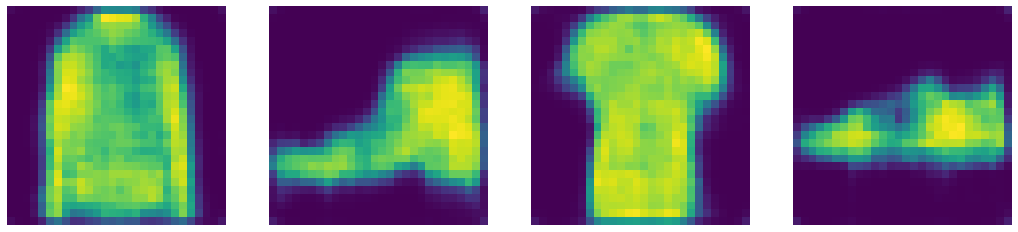

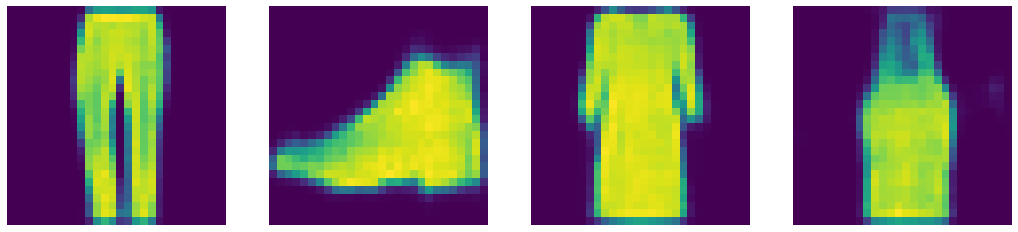

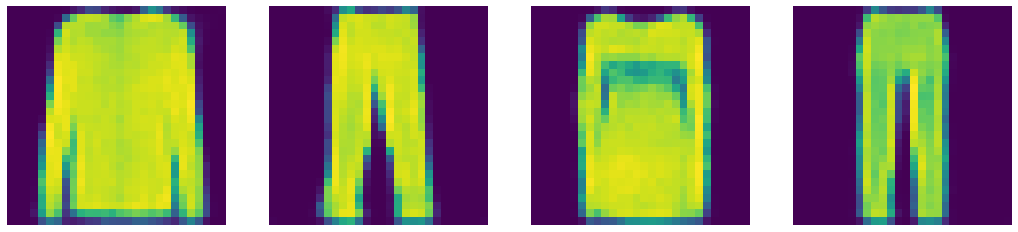

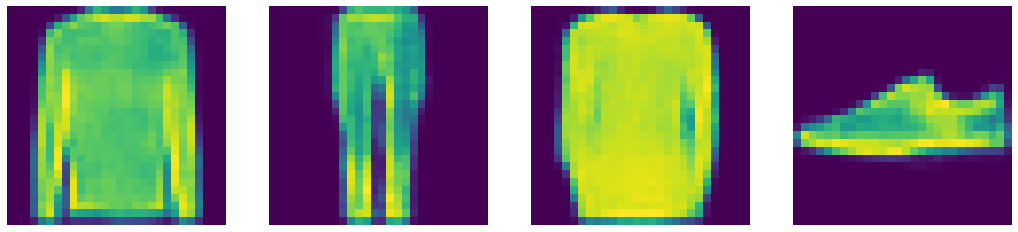

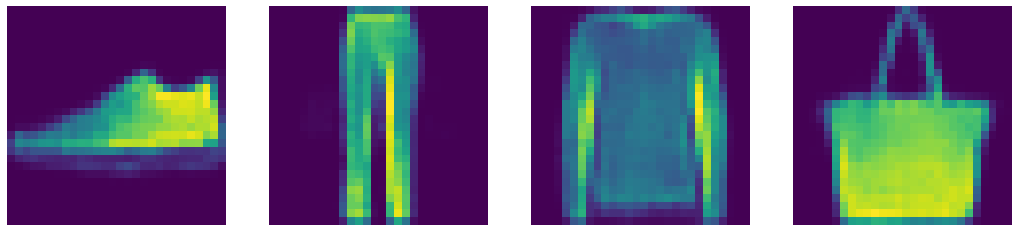

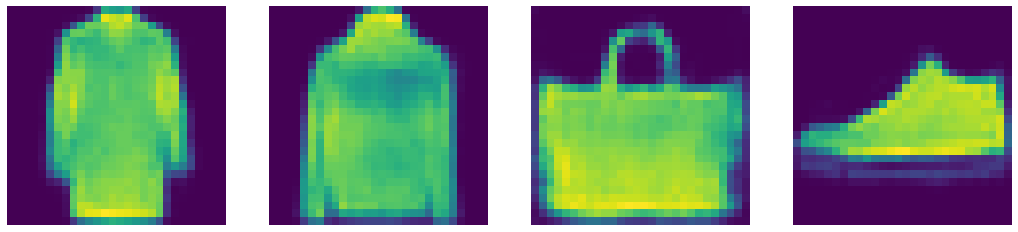

In [59]:
num_epochs = 30
vae_loss = []
for epoch in range(num_epochs):
    for data in trainloader:
        img, _ = data
        img = img.to(device)
        img.requires_grad_()
        output,mu,var = model_vae(img)  
        loss = loss_function(output,img.data,mu,var,beta)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    # ===================log========================
    if epoch%5 == 0:
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
        display_images(None, output)
        vae_loss.append(loss.item())

In [0]:
from torch.autograd import Variable
plt.style.use('default')
%matplotlib inline 

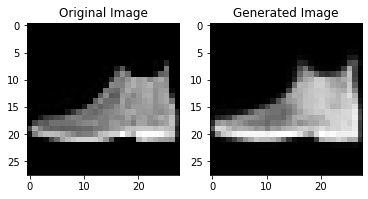

In [64]:
model_vae = model_vae.cpu()
test_images, labels = next(iter(testloader))

test_images = Variable(test_images)
test_output,_,_ = model_vae(test_images)
  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')

plot = fig.add_subplot(1, 2, 2)
plot.set_title('Generated Image')
imgplot = plt.imshow(out[0].cpu().detach(), cmap='gray')
plt.show()

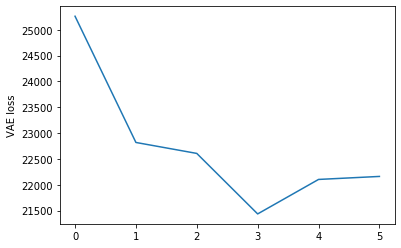

In [65]:
plt.plot(vae_loss)
plt.ylabel('VAE loss')
plt.show()